## Overview

This notebook demonstrates how to get started with using the OpenAI library and demonstrates how to leverage multimodal capabilities of Llama 3.2 models as Model-as-service (MaaS).

### Objective

- Configure OpenAI SDK for the Llama 3.2 Completions API
- Chat with Llama 3.2 models with different prompts and model parameters
- Build and use Llama 3.2 GenAI powered application for Car Damage Assessment.

### Costs

This tutorial uses billable components of Google Cloud:

* Vertex AI
* Cloud Storage

Learn about [Vertex AI pricing](https://cloud.google.com/vertex-ai/pricing), [Cloud Storage pricing](https://cloud.google.com/storage/pricing), and use the [Pricing Calculator](https://cloud.google.com/products/calculator/) to generate a cost estimate based on your projected usage.

## Get started

### Install Vertex AI SDK for Python and other required packages


In [2]:
! pip3 install --upgrade --quiet google-cloud-aiplatform openai gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 49.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 389.5/389.5 kB 23.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.1/57.1 MB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.1/320.1 kB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.9/94.9 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.1/11.1 MB 64.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.2/73.2 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 7.2 MB/s eta 0:00:00


### Restart runtime (Colab only)

To use the newly installed packages, you must restart the runtime on Google Colab.

In [4]:
import sys

if "google.colab" in sys.modules:

    import IPython

    app = IPython.Application.instance()
    app.kernel.do_shutdown(True)

In [1]:
import sys

if "google.colab" in sys.modules:

    from google.colab import auth

    auth.authenticate_user()

### Set Google Cloud project information

To get started using Vertex AI, you must have an existing Google Cloud project and [enable the Vertex AI API](https://console.cloud.google.com/flows/enableapi?apiid=aiplatform.googleapis.com). Learn more about [setting up a project and a development environment](https://cloud.google.com/vertex-ai/docs/start/cloud-environment).

In [ ]:
PROJECT_ID = "upheld-quanta-442214-i7"  # @param {type:"string"}

# Only `us-central1` is supported region for Llama 3.2 models using Model-as-a-Service (MaaS).
LOCATION = "us-central1"

### Create a Cloud Storage bucket

Create a storage bucket to store tutorial artifacts.

In [2]:
BUCKET_NAME = "cuhk_fashion_report_2024"  # @param {type:"string"}

BUCKET_URI = f"gs://{BUCKET_NAME}"

In [3]:
! gsutil mb -l {LOCATION} -p {PROJECT_ID} {BUCKET_URI}

Creating gs://cuhk_fashion_report_2024/...
ServiceException: 409 A Cloud Storage bucket named 'cuhk_fashion_report_2024' already exists. Try another name. Bucket names must be globally unique across all Google Cloud projects, including those outside of your organization.


### Initialize Vertex AI SDK for Python

In [4]:
import vertexai

vertexai.init(project=PROJECT_ID, location=LOCATION, staging_bucket=BUCKET_URI)

### Import libraries

Import libraries to use in this tutorial.

In [5]:
import json
import re
import uuid
from io import BytesIO

import gradio as gr
import matplotlib.pyplot as plt
# Chat completions API
import openai
from google.auth import default, transport
from google.cloud import storage
from PIL import Image

In [6]:
def visualize_image_from_bucket(bucket_name: str, blob_name: str) -> None:
    """Visualizes an image stored in a Google Cloud Storage bucket."""
    try:
        # Create a client for interacting with Google Cloud Storage
        storage_client = storage.Client()

        # Get a reference to the bucket and blob
        bucket = storage_client.bucket(bucket_name)
        blob = bucket.blob(blob_name)

        # Download the image data into memory
        image_data = blob.download_as_bytes()

        # Open the image using PIL
        image = Image.open(BytesIO(image_data))

        # Display the image using matplotlib
        plt.figure(figsize=(10, 10))  # Set the figure size (adjust as needed)
        plt.imshow(image)
        plt.axis("off")  # Turn off axis labels
        plt.show()

    except Exception as e:
        print(f"Error visualizing image: {e}")

### Configure OpenAI SDK for the Llama 3.2 Chat Completions API

To configure the OpenAI SDK for the Llama 3.2 Chat Completions API, you need to request the access token and initialize the client pointing to the Llama 3.2 endpoint.


#### Authentication



In [7]:
credentials, _ = default()
auth_request = transport.requests.Request()
credentials.refresh(auth_request)

Then configure the OpenAI SDK to point to the Llama 3.2 Chat Completions API endpoint.

Notice, only `us-central1` is supported region for Llama 3.2 models using Model-as-a-Service (MaaS).

In [8]:
MODEL_LOCATION = "us-central1"
MAAS_ENDPOINT = f"{MODEL_LOCATION}-aiplatform.googleapis.com"

client = openai.OpenAI(
    base_url=f"https://{MAAS_ENDPOINT}/v1beta1/projects/{PROJECT_ID}/locations/{LOCATION}/endpoints/openapi",
    api_key=credentials.token,
)

#### Llama 3.2 models

You can experiment with various supported Llama 3.2 models.

This tutorial use Llama 3.2 90B Vision Instruct using Model-as-a-Service (MaaS). Using Model-as-a-Service (MaaS), you can access Llama 3.2 models in just a few clicks without any setup or infrastructure hassles.

You can also access Llama models for self-service in Vertex AI Model Garden, allowing you to choose your preferred infrastructure. [Check out Llama 3.2 model card](https://console.cloud.google.com/vertex-ai/publishers/meta/model-garden/llama3-2?_ga=2.31261500.2048242469.1721714335-1107467625.1721655511) to learn how to deploy a Llama 3.2 models on Vertex AI.

In [14]:
MODEL_ID = "meta/llama-3.2-90b-vision-instruct-maas"  # @param {type:"string"} ["meta/llama-3.2-90b-vision-instruct-maas"]

### Chat with Llama 3.2

Use the Chat Completions API to send a multi-model request to the Llama 3.2 model.

#### Hello, Llama 3.2 90B  Yeah!

In [31]:
prompt = """
    Background:
    I am working on a data science master's project focused on fashion. The project involves analyzing 10,000 images to retrieve specific attributes. For each image, please identify and select relevant attributes from the provided lists. The output should strictly follow the JSON format shown in the example below.
    ________________________________________
    Instructions:
    1. Category Selection:
    Identify and categorize each fashion item image based on the following categories. Ensure that each category is uniquely numbered and clearly defined.
    • Category 0: Fashion Main Category
        o Description: Broad primary categories encompassing all types of fashion items.
        o Examples: Clothing, Footwear, Accessories, Outerwear, Bags, Jewelry, Hats.
    • Category 1: Fashion Item Sub Category
        o Description: Specific subcategories under each main category for precise classification.
        o Examples: Blazer, Jeans, T-Shirt, Sneakers, Handbag, Necklace, Fedora.
    • Category 2: Patterns, Prints, and Graphics
        o Description: Details the visual patterns or graphics on the fashion item.
        o Examples: Stripes, Plaid, Floral, Solid, Geometric, Camouflage, Abstract, None.
    • Category 3: Materials, Fabrics, and Finishes
        o Description: Specifies the materials and fabric compositions used.
        o Examples: 100% Merino Wool, Modal Fiber Blend, Recycled Polyester, Brushed Chenille, Organic Cotton, Denim, Leather, Satin.
    • Category 4: Fit
        o Description: Describes how the clothing item fits the body.
        o Examples: Fitted, Relaxed, Oversized, Tailored, Slim, Regular, Loose.
    • Category 5: Silhouette
        o Description: Refers to the overall shape or outline of the garment.
        o Examples: Slim, Boxy, A-line, Straight, Flared, Peplum, Structured.
    • Category 6: Length
        o Description: Indicates the length of the clothing item.
        o Examples: Mini, Knee-length, Midi, Ankle, Maxi, Cropped, Floor-length.
    • Category 7: Design Features
        o Description: Highlights specific design features and elements.
        o Examples: Double-breasted, Notched Collar, Asymmetric Hem, Patch Pockets, Zipper Closures, Embroidery, Sequins, Ruffles, Buttons, Belted Waist.
    • Category 8: Embellishments
        o Description: Details any additional decorative elements.
        o Examples: Embroidery, Sequins, Patches, Appliqués, Beading.
    • Category 9: Style, Theme, and Overall Inspiration
        o Description: Captures the overarching style or thematic inspiration behind the design.
        o Examples: Classic, Minimalist, Bohemian, Streetwear, Audrey Hepburn-inspired, Americana, Retro, Avant-garde, Sustainable, Futuristic.
    • Category 10: Main Color
        o Description: Dominant color of the fashion item.
        o Examples: White, Black, Red, Blue, Green, Yellow, Pink, Purple, Neutral Tones, Pastels, Metallics, Pantone 11-0602 TCX (White), Pantone 14-0852 TCX (Spectra Yellow).
    • Category 11: Sub Color
        o Description: Secondary or accent colors present in the item.
        o Examples: Off-white, Cream, Light Beige, Ivory, Neon Green, Metallic Silver, Navy Blue, Dusty Rose, Burnt Orange, Sky Blue.
    • Category 12: Usage Categories
        o Description: Contexts or occasions for which the item is intended.
        o Examples: Formal Wear, Casual, Business Casual, Athletic, Evening Wear, Streetwear, Resort Wear, Wedding, Office, Party, Travel.
    • Category 13: Gender-Based Categories
        o Description: Specifies the intended gender for the fashion item.
        o Examples: Male, Female, Non-binary, Gender Fluid, Unisex.
    • Category 14: Seasonality
        o Description: Specifies the season(s) the item is designed for.
        o Examples: Spring, Summer, Fall, Winter, All-Season.
    • Category 15: Embellishments and Accessories
        o Description: Details any additional decorative elements or attached accessories.
        o Examples: Belts, Hoods, Scarves, Patches, Appliqués.
    • Category 16: Closure Type
        o Description: Describes how the garment is fastened.
        o Examples: Buttons, Zipper, Hook and Loop, Tie, Snap.
    • Category 17: Target Age Group
        o Description: Specifies the intended age demographic for the fashion item.
        o Examples: Teens (13-19), Young Adults (20-30), Adults (31-50), Seniors (51+), Children (Under 13), All Ages.

    #### 2. Output Format:
    • Your response should only be a JSON object covering Categories 0 to 17.
    • If Category 0 is selected as "Other", "Not Applicable", or "N/A", set all Categories 1 to 17 to "N/A".
    • Follow the JSON example below precisely. Do not include any additional text or explanations. Do not include any additional text or explanations, other than JSON.

    #### 3. JSON Example:
    ```json
    {
      "Category 0: Fashion Main Category": "Clothing",
      "Category 1: Fashion Item Sub Category": "Blazer",
      "Category 2: Patterns, Prints, and Graphics": "Solid",
      "Category 3: Materials, Fabrics, and Finishes": "100% Merino Wool",
      "Category 4: Fit": "Fitted",
      "Category 5: Silhouette": "Tailored",
      "Category 6: Length": "Ankle-length",
      "Category 7: Design Features": "Double-breasted, Notched Collar, Asymmetric Hem",
      "Category 8: Embellishments": "None",
      "Category 9: Style, Theme, and Overall Inspiration": "Classic, Americana, Audrey Hepburn-inspired",
      "Category 10: Main Color": "White, Pantone 11-0602 TCX",
      "Category 11: Sub Color": "Off-white, Cream",
      "Category 12: Usage Categories": "Formal Wear",
      "Category 13: Gender-Based Categories": "Unisex",
      "Category 14: Seasonality": "Winter",
      "Category 15: Embellishments and Accessories": "None",
      "Category 16: Closure Type": "Buttons",
      "Category 17: Target Age Group": "Young Adults (20-30)"
    }
    """

In [ ]:
max_tokens = 4096

response = client.chat.completions.create(
    model=MODEL_ID,
    messages=[
        {
            "role": "user",
            "content": [
                {
                    "image_url": {
                        "url": "gs://cuhk_fashion_report_2024/image100_section_1.jpg"
                    },
                    "type": "image_url",
                },
                {"text": prompt, "type": "text"},
            ],
        },
        {"role": "assistant", "content": "In this image, you have:"},
    ],
    temperature=1.0,
    max_tokens=max_tokens,
    top_p=1.0
)

print(response.choices[0].message.content)

You get the response as shown below.

In [27]:
print(response.choices[0].message.content)

Two published images of a Chinese actress. 

In the first image, the actress is holding a coffee cup in her left hand and her right hand is holding a cell phone.  

The words NCIST 97 appear on the front of her t-shirt with other lesser visible letters.

In the second image, the actress is smoothing her hair while performing the same combined actions as the first photo. The word "Marter" appears on her jacket.


You use the helper function to visualize the image.

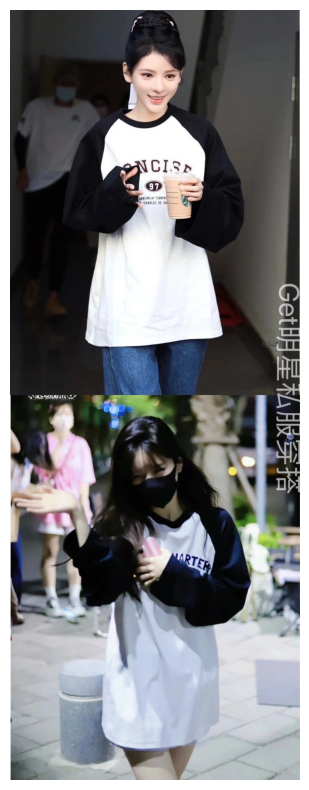

In [30]:
visualize_image_from_bucket("cuhk_fashion_report_2024", "image100_section_1.jpg")

#### Use Llama 3.2 with different multimodal tasks

In this section, you will use Llama 3.2 to perform different multimodal tasks including image captioning and Visual Question Answering (VQA).

For each task, you'll define a different prompt and submit a request to the model as you did before.

In [ ]:
visualize_image_from_bucket("github-repo", "img/gemini/intro/landmark3.jpg")

##### Image captioning

In [ ]:
prompt = "Imagine you're telling a friend about this photo. What would you say?"

In [ ]:
response = client.chat.completions.create(
    model=MODEL_ID,
    messages=[
        {
            "role": "user",
            "content": [
                {
                    "image_url": {
                        "url": "gs://github-repo/img/gemini/intro/landmark3.jpg"
                    },
                    "type": "image_url",
                },
                {"text": prompt, "type": "text"},
            ],
        },
    ],
    max_tokens=max_tokens,
)

In [ ]:
print(response.choices[0].message.content)

##### Visual Question Answering (VQA)

In [ ]:
prompt = """
Analyze this image and answer the following questions:
- What is the primary color in the image?
- What is the overall mood or atmosphere conveyed in the scene?
- Based on the visual clues, who might have taken the picture?"
"""

In [ ]:
response = client.chat.completions.create(
    model=MODEL_ID,
    messages=[
        {
            "role": "user",
            "content": [
                {
                    "image_url": {
                        "url": "gs://github-repo/img/gemini/intro/landmark3.jpg"
                    },
                    "type": "image_url",
                },
                {"text": prompt, "type": "text"},
            ],
        },
    ],
    max_tokens=max_tokens,
)

In [ ]:
print(response.choices[0].message.content)

### Build with Llama 3.2 : Car Damage Assessment app using Gradio

In this section, you use Llama 3.2 to build a simple GenAI powered application for Car Damage Assessment.

In this scenario, the app has to cover the following tasks:

*   Classify the type of damage
*   Estimate the damage severity
*   Estimate the damage cost


#### Define the UI functions

In [ ]:
def upload_image_to_bucket(image_path: str) -> str:
    """Uploads an image to a Google Cloud Storage bucket."""
    try:
        # Create a client for interacting with Google Cloud Storage
        storage_client = storage.Client()

        # Get a reference to the bucket
        bucket = storage_client.bucket(BUCKET_NAME)

        # Generate a unique blob name based on the file extension
        file_extension = image_path.split(".")[-1].lower()
        if file_extension in ["jpg", "jpeg"]:
            blob_name = f"car_damage_{uuid.uuid4()}.jpg"
        else:
            blob_name = f"car_damage_{uuid.uuid4()}.png"

        # Get a reference to the blob and upload the image
        blob = bucket.blob(blob_name)
        blob.upload_from_filename(image_path)

        # Construct the URI of the uploaded image
        image_uri = f"gs://{BUCKET_NAME}/{blob_name}"
        return image_uri

    except Exception as e:
        print(f"Error uploading image: {e}")


def parse_json_from_markdown(markdown_text: str) -> dict | None:
    """Extracts and parses JSON content embedded within Markdown text."""
    json_pattern = r"```json\n(.*?)\n```"
    match = re.search(json_pattern, markdown_text, re.DOTALL)

    if match:
        json_content = match.group(1)
        try:
            parsed_data = json.loads(json_content)
            return parsed_data
        except json.JSONDecodeError as e:
            print(f"Error: Invalid JSON content found. {e}")
            return None
    else:
        return None


def process_image(image_uri):
    """Processes a car damage image using a multimodal LLM."""

    # Construct the prompt
    prompt = """
    Analyze the provided image of a car and provide the following information:

    1. Damage Type: Identify the primary type of damage visible in the image (e.g., dent, scratch, cracked windshield, etc.).
    2. Severity: Estimate the severity of the damage on a scale of 1 to 5, where 1 is minor and 5 is severe.
    3. Estimated Repair Cost: Provide an approximate range for the repair cost in USD.

    Return the results in JSON format with damagetype, severity, and cost fields.
    """

    # Call Llama model
    credentials, _ = default()
    auth_request = transport.requests.Request()
    credentials.refresh(auth_request)

    client = openai.OpenAI(
        base_url=f"https://{MAAS_ENDPOINT}/v1beta1/projects/{PROJECT_ID}/locations/{LOCATION}/endpoints/openapi",
        api_key=credentials.token,
    )
    response = client.chat.completions.create(
        model=MODEL_ID,
        messages=[
            {
                "role": "user",
                "content": [
                    {"image_url": {"url": image_uri}, "type": "image_url"},
                    {"text": prompt, "type": "text"},
                ],
            },
        ],
        max_tokens=max_tokens,
    )

    # Parse the response
    response = response.choices[0].message.content
    output = parse_json_from_markdown(response)

    output = {"damagetype": "scratch", "severity": 5, "cost": 1000}
    return output["damagetype"], output["severity"], output["cost"]


def demo_fn(image_path):
    """
    Processes a car damage image using a multimodal LLM.
    """

    # Upload the image
    image_uri = upload_image_to_bucket(image_path)

    # Process the image
    damagetype, severity, cost = process_image(image_uri)

    return damagetype, severity, cost

#### Run the application

In [ ]:
demo = gr.Interface(
    fn=demo_fn,
    inputs=gr.Image(type="filepath"),
    outputs=[
        gr.Textbox(label="Damage Type"),
        gr.Slider(label="Severity", minimum=1, maximum=10, step=1),
        gr.Number(label="Cost"),
    ],
    title="Car Damage Assessment",
)

demo.launch(debug=True)

In [ ]:
demo.close()

## Cleaning up

Clean up resources created in this notebook.

To delete to the search engine in Vertex AI, check out the following [documentation](https://cloud.google.com/generative-ai-app-builder/docs/delete-engine).

In [ ]:
delete_bucket = False  # @param {type:"boolean"}

if delete_bucket:
    ! gsutil -m rm -r $BUCKET_NAME